In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [55]:
data = pd.read_csv("fraudTrain.csv")
data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [57]:
# extract age of customer
data['dob'] = pd.to_datetime(data['dob'])
data['age'] = (pd.to_datetime(data['trans_date_trans_time']).dt.year - data['dob'].dt.year)

In [58]:
# categorise ages
def age_group(age):
    if age < 18:
        return 'Teen'
    elif age < 25:
        return 'Young Adult'
    elif age < 35:
        return 'Adult'
    elif age < 50:
        return 'Middle-aged'
    elif age < 65:
        return 'Senior'
    else:
        return 'Elderly'

data['age_group'] = data['age'].apply(age_group)

In [59]:
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data['day'] = data['trans_date_trans_time'].dt.day
data['month'] = data['trans_date_trans_time'].dt.month
data['year'] = data['trans_date_trans_time'].dt.year
data['hour'] = data['trans_date_trans_time'].dt.hour
data['minute'] = data['trans_date_trans_time'].dt.minute

In [60]:
# extrcat distance

# Define haversine function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])  # Convert to radians

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c  # Distance in km

# Apply to dataframe
data['distance_km'] = haversine(data['lat'], data['long'], data['merch_lat'], data['merch_long'])


In [61]:
data['distance_km'].max()

np.float64(152.11717310595034)

In [62]:
data['distance_km'].min()

np.float64(0.022254515638533652)

In [63]:
# categorise distances for better predictions
def distance_category(dist):
    if dist < 0.5:
        return 'Very Near'         # < 500 meters
    elif dist < 3:
        return 'Near'              # 0.5 – 3 km
    elif dist < 15:
        return 'Moderate'          # 3 – 15 km
    elif dist < 50:
        return 'Far'               # 15 – 50 km
    else:
        return 'Very Far'          # 50 – 152+ km

data['distance_group'] = data['distance_km'].apply(distance_category)


In [64]:
# dropping irrelevant columns
cols_to_drop = [
    'Unnamed: 0', 'first', 'last', 'street', 'city', 'state', 'zip',
    'dob', 'cc_num', 'trans_num', 'unix_time',
    'lat', 'long', 'merch_lat', 'merch_long', 'trans_date_trans_time',
]

data.drop(columns=cols_to_drop, inplace=True)

In [65]:
data.columns

Index(['merchant', 'category', 'amt', 'gender', 'city_pop', 'job', 'is_fraud',
       'age', 'age_group', 'day', 'month', 'year', 'hour', 'minute',
       'distance_km', 'distance_group'],
      dtype='object')

In [66]:
# getting sample data
sample_data = data.sample(frac=0.005, random_state=42)
len(sample_data)

6483

In [67]:
# extracting X and y from sample data
X = sample_data.drop(columns=['is_fraud'])
y = sample_data['is_fraud']

In [68]:
from sklearn.model_selection import train_test_split

# Split while preserving class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=42,
    stratify=y   # ✅ ensures class balance in both splits
)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print()
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (5510, 15)
y_train shape: (5510,)

X_test shape: (973, 15)
y_test shape: (973,)


In [69]:
cols = X_train.columns
print(cols)
print()
cat_cols = X_train.select_dtypes(include="object").columns
print(cat_cols)

Index(['merchant', 'category', 'amt', 'gender', 'city_pop', 'job', 'age',
       'age_group', 'day', 'month', 'year', 'hour', 'minute', 'distance_km',
       'distance_group'],
      dtype='object')

Index(['merchant', 'category', 'gender', 'job', 'age_group', 'distance_group'], dtype='object')


In [70]:
data.columns

Index(['merchant', 'category', 'amt', 'gender', 'city_pop', 'job', 'is_fraud',
       'age', 'age_group', 'day', 'month', 'year', 'hour', 'minute',
       'distance_km', 'distance_group'],
      dtype='object')

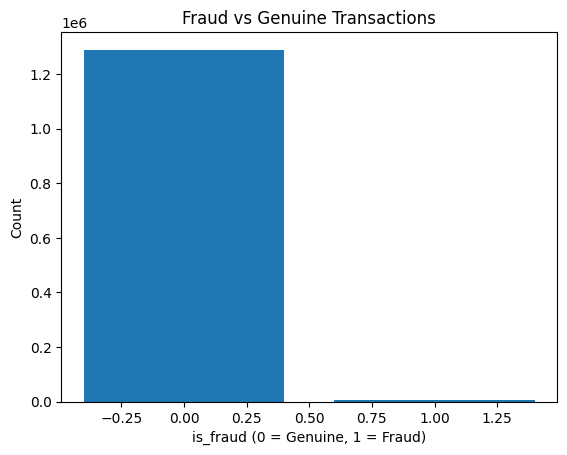

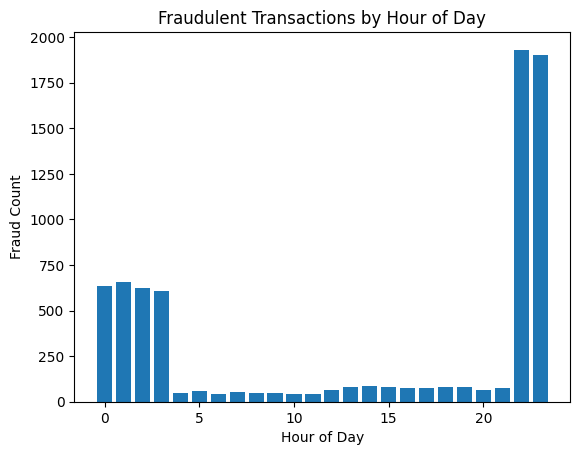

In [71]:
import pandas as pd
import matplotlib.pyplot as plt



# ---- Plot 1: Class distribution ----
fraud_counts = data['is_fraud'].value_counts()
plt.figure()
plt.bar(fraud_counts.index, fraud_counts.values)
plt.title('Fraud vs Genuine Transactions')
plt.xlabel('is_fraud (0 = Genuine, 1 = Fraud)')
plt.ylabel('Count')
plt.show()





fraud_by_hour = data[data['is_fraud']==1]['hour'].value_counts().sort_index()
plt.figure()
plt.bar(fraud_by_hour.index, fraud_by_hour.values)
plt.title('Fraudulent Transactions by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Count')
plt.show()


In [72]:
# OrdinalEncoder can tranform all cols at once, instead of one-by-one in LabelEncoding
from sklearn.preprocessing import OrdinalEncoder

# Select categorical columns
cat_cols = sample_data.select_dtypes(include="object").columns.tolist()

# Initialize encoder with unknown handling
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Fit on training data and transform both train and test
X_train[cat_cols] = encoder.fit_transform(X_train[cat_cols])
X_test[cat_cols] = encoder.transform(X_test[cat_cols])

In [73]:
# that's why i extracted cat_cols above, to scale the numeric cols only
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5510 entries, 458043 to 789415
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   merchant        5510 non-null   float64
 1   category        5510 non-null   float64
 2   amt             5510 non-null   float64
 3   gender          5510 non-null   float64
 4   city_pop        5510 non-null   int64  
 5   job             5510 non-null   float64
 6   age             5510 non-null   int32  
 7   age_group       5510 non-null   float64
 8   day             5510 non-null   int32  
 9   month           5510 non-null   int32  
 10  year            5510 non-null   int32  
 11  hour            5510 non-null   int32  
 12  minute          5510 non-null   int32  
 13  distance_km     5510 non-null   float64
 14  distance_group  5510 non-null   float64
dtypes: float64(8), int32(6), int64(1)
memory usage: 559.6 KB


In [74]:
# scaling the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
 
num_cols = [ col for col in cols if col not in cat_cols ]
print(num_cols)

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()


X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

['amt', 'city_pop', 'age', 'day', 'month', 'year', 'hour', 'minute', 'distance_km']


In [75]:
X_train_scaled.columns

Index(['merchant', 'category', 'amt', 'gender', 'city_pop', 'job', 'age',
       'age_group', 'day', 'month', 'year', 'hour', 'minute', 'distance_km',
       'distance_group'],
      dtype='object')

In [76]:
print(type(y_test))
print(type(y_train))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


Accuracy        : 0.8869475847893115
Precision       : 0.03571428571428571
Recall          : 0.6666666666666666
Confusion Matrix:
 [[859 108]
 [  2   4]]


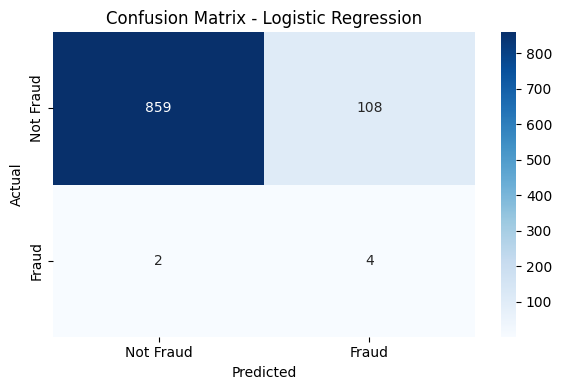

In [77]:
# 1. LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
#import seaborn as sns

# Model
lr = LogisticRegression(solver='lbfgs', penalty="l2", class_weight='balanced', random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)

# Predict
y_pred = lr.predict(X_test_scaled)

# Metrics
print("Accuracy        :", accuracy_score(y_test, y_pred))
print("Precision       :", precision_score(y_test, y_pred, zero_division=0))
print("Recall          :", recall_score(y_test, y_pred))

# Confusion matrix
conf_mt = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_mt)


plt.figure(figsize=(6, 4))
sns.heatmap(conf_mt, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()


In [78]:
# getting feature relevancy using coeff
feature_names = X_train.columns
coefficients = lr.coef_[0]

# Step 2: Create a DataFrame to sort by importance
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': np.abs(coefficients)
}).sort_values(by='Importance', ascending=False)

# Step 3: View top N important features
print(coef_df.head(10))

           Feature  Coefficient  Importance
2              amt     1.661616    1.661616
14  distance_group    -0.975533    0.975533
3           gender     0.879944    0.879944
9            month     0.775937    0.775937
13     distance_km     0.677078    0.677078
11            hour    -0.403820    0.403820
4         city_pop     0.244850    0.244850
10            year    -0.173969    0.173969
1         category    -0.145665    0.145665
6              age    -0.096381    0.096381


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define base model
nb = GaussianNB()

# 2. Define parameter grid manually (powers of 10 between 1e-12 and 1e-6)
param_dist = {
    'var_smoothing': np.logspace(-12, -6, 50)  # 50 values from 1e-12 to 1e-6
}

# 3. Randomized Search with CV
rand_search = RandomizedSearchCV(
    estimator=nb,
    param_distributions=param_dist,
    n_iter=20,              # try 20 random values
    cv=5,                   # 5-fold cross-validation
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

# 4. Fit model on training data
rand_search.fit(X_train_scaled, y_train)

print("Best Parameters:", rand_search.best_params_)
print("Best CV Accuracy:", rand_search.best_score_)

# 5. Predict on test data
y_pred = rand_search.predict(X_test_scaled)

# 6. Evaluation Metrics
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_mt = confusion_matrix(y_test, y_pred)

print("Test Accuracy :", acc)
print("Precision     :", precision)
print("Recall        :", recall)
print("Confusion Matrix:\n", conf_mt)

# 7. Confusion Matrix Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mt, annot=True, fmt='d', cmap='Greens',
            xticklabels=["Not Fraud", "Fraud"],
            yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naive Bayes (Random Search)")
plt.tight_layout()
plt.show()


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import joblib

# Initialize model with some overfitting control
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=class_weight_ratio,  # handle imbalance
    n_estimators=150,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

# Train the model
xgb.fit(X_train, y_train)

# Predict
y_pred = xgb.predict(X_test)

# Evaluate
print("Accuracy       :", accuracy_score(y_test, y_pred))
print("Precision      :", precision_score(y_test, y_pred))
print("Recall         :", recall_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Save model for Streamlit
joblib.dump(xgb, "xgb_model.pkl")
print("Model saved as xgb_model.pkl")

Accuracy       : 0.9969167523124358
Precision      : 0.7142857142857143
Recall         : 0.8333333333333334
Confusion Matrix:
 [[965   2]
 [  1   5]]
Model saved as xgb_model.pkl


c:\Users\hayaa\OneDrive\Desktop\data sci sum pro\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:15:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Dictionary to store results
results = {}

# Logistic Regression
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
results['Logistic Regression'] = {
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'Precision': precision_score(y_test, y_pred_lr),
    'Recall': recall_score(y_test, y_pred_lr),
    'F1-Score': f1_score(y_test, y_pred_lr),
    'ROC-AUC': roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:,1])
}

# Naive Bayes
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
y_pred_nb = nb.predict(X_test_scaled)
results['Naive Bayes'] = {
    'Accuracy': accuracy_score(y_test, y_pred_nb),
    'Precision': precision_score(y_test, y_pred_nb),
    'Recall': recall_score(y_test, y_pred_nb),
    'F1-Score': f1_score(y_test, y_pred_nb),
    'ROC-AUC': roc_auc_score(y_test, nb.predict_proba(X_test_scaled)[:,1])
}

# XGBoost
xgb = XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss',
    scale_pos_weight=class_weight_ratio,
    n_estimators=150,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
results['XGBoost'] = {
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb),
    'Recall': recall_score(y_test, y_pred_xgb),
    'F1-Score': f1_score(y_test, y_pred_xgb),
    'ROC-AUC': roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1])
}

# Show results in a DataFrame
results_df = pd.DataFrame(results).T
print("Model Performance Comparison:")
display(results_df)


c:\Users\hayaa\OneDrive\Desktop\data sci sum pro\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:15:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model Performance Comparison:


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Logistic Regression,0.886948,0.035714,0.666667,0.067797,0.907618
Naive Bayes,0.988695,0.142857,0.166667,0.153846,0.927611
XGBoost,0.996917,0.714286,0.833333,0.769231,0.987763


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# -------------------------
# Train & Evaluate Models
# -------------------------
results = {}

# Logistic Regression
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
results['Logistic Regression'] = {
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'Precision': precision_score(y_test, y_pred_lr),
    'Recall': recall_score(y_test, y_pred_lr),
    'F1-Score': f1_score(y_test, y_pred_lr),
    'ROC-AUC': roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:,1])
}

# Naive Bayes
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
y_pred_nb = nb.predict(X_test_scaled)
results['Naive Bayes'] = {
    'Accuracy': accuracy_score(y_test, y_pred_nb),
    'Precision': precision_score(y_test, y_pred_nb),
    'Recall': recall_score(y_test, y_pred_nb),
    'F1-Score': f1_score(y_test, y_pred_nb),
    'ROC-AUC': roc_auc_score(y_test, nb.predict_proba(X_test_scaled)[:,1])
}

# XGBoost
xgb = XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss',
    scale_pos_weight=class_weight_ratio,
    n_estimators=150,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
xgb.fit(X_train, y_train)  # XGBoost works on unscaled data
y_pred_xgb = xgb.predict(X_test)
results['XGBoost'] = {
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb),
    'Recall': recall_score(y_test, y_pred_xgb),
    'F1-Score': f1_score(y_test, y_pred_xgb),
    'ROC-AUC': roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1])
}

# Show comparison table
results_df = pd.DataFrame(results).T
print("Model Performance Comparison:")
display(results_df)

# -------------------------
# Predict on New Raw Input
# -------------------------

# Example raw input (MAKE SURE column names match X_train.columns)
new_input = pd.DataFrame([{
    "merchant": "M123",
    "category": "shopping_pos",
    "amt": 120.50,
    "gender": "F",
    "city_pop": 54000,
    "job": "Engineer",
    "age": 29,
    "age_group": "Young Adult",
    "day": 15,
    "month": 8,
    "year": 2023,
    "hour": 14,
    "minute": 35,
    "distance_km": 12.4,       # ⚡ must match training column name
    "distance_group": "Near"
}])

# --- Validate Columns ---
missing_cols = [col for col in X_train.columns if col not in new_input.columns]
extra_cols = [col for col in new_input.columns if col not in X_train.columns]

if missing_cols:
    print("⚠️ Missing columns in input:", missing_cols)
if extra_cols:
    print("⚠️ Extra columns not used in training:", extra_cols)

# Reorder input columns to match training
new_input = new_input.reindex(columns=X_train.columns, fill_value=0)

# --- Preprocessing ---
# Encode categorical
new_input_enc = new_input.copy()
new_input_enc[cat_cols] = encoder.transform(new_input_enc[cat_cols])

# Scale numeric
new_input_scaled = new_input_enc.copy()
new_input_scaled[num_cols] = scaler.transform(new_input_enc[num_cols])

# --- Predictions ---
print("\nPrediction on New Transaction:")
print("Logistic Regression:", lr.predict(new_input_scaled)[0], "| Prob:", round(lr.predict_proba(new_input_scaled)[0][1], 4))
print("Naive Bayes        :", nb.predict(new_input_scaled)[0], "| Prob:", round(nb.predict_proba(new_input_scaled)[0][1], 4))
print("XGBoost            :", xgb.predict(new_input_enc)[0], "| Prob:", round(xgb.predict_proba(new_input_enc)[0][1], 4))


Model Performance Comparison:


c:\Users\hayaa\OneDrive\Desktop\data sci sum pro\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:15:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Logistic Regression,0.886948,0.035714,0.666667,0.067797,0.907618
Naive Bayes,0.988695,0.142857,0.166667,0.153846,0.927611
XGBoost,0.996917,0.714286,0.833333,0.769231,0.987763



Prediction on New Transaction:
Logistic Regression: 0 | Prob: 0.0032
Naive Bayes        : 0 | Prob: 0.0
XGBoost            : 0 | Prob: 1e-04
